# Part 0: Introduction and Imports

This project guides you through the general pipeline used to build and train a convolutional neural network (CNN) for an image classification task. You'll be implementing a baseline model, improving upon your baseline model, and trying to fool your CNN with adversarial images.


We will be using a library called PyTorch which simplifies many of the low-level implementation details of neural networks for us, so that we can focus on the high-level deep learning concepts.


### Using this notebook
This notebook will walk you through the different parts of the assignment, with detailed instructions and explanations at every step. You'll see todos for things you need to write in `student.py`.

In [14]:

%matplotlib inline

# Imports

import numpy as np
import sys
import os
from datetime import datetime

import matplotlib
from matplotlib import pyplot as plt


import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets


# Constants
classes = [
     'bighorn-sheep',
     'bison',
     'black-stork',
     'brown-bear',
     'bullfrog',
     'camel',
     'gazelle',
     'golden-retriever',
     'goldfish',
     'ladybug',
     'lion',
     'orangutan',
     'penguin',
     'persian-cat',
     'pig',
     'puma'
]


# Part 1: Reading the data

### Step 1: Unpacking the dataset

Unzip the `data.zip` file. You should now have a folder called `data` with this structure:

```
data/
    train/
        bighorn-sheep/
            XXXX.JPEG
        goldfish/
            XXXX.JPEG
        ...
    val/
        bighorn-sheep/
            XXXX.JPEG
        goldfish/
            XXXX.JPEG
        ...
    test/
        bighorn-sheep/
            XXXX.JPEG
        goldfish/
            XXXX.JPEG
        ...
```

The names of the actual images (`XXXX.JPEG` in the diagram above) don't matter - only the folder structure matters, where the names of the folders under `train/`, `val/` and `test/` correspond to the class names.

**Data summary:**
There are 16 classes, each with 500 training images and 50 validation images. Each image is 64x64 with 3 channels.

The classes are the following:
```
bighorn-sheep
bison
black-stork
brown-bear
bullfrog
camel
gazelle
golden-retriever
goldfish
ladybug
lion
orangutan
penguin
persian-cat
pig
puma
```


### Step 2: A quick sanity check...
Before training any machine learning model, it's important to fully understand the data that is being dealt with. What does it look like, and does it match our expectations? In this part, we'll run code that looks into the dataset and shows us what it contains.

To help with this, we have first defined a `visualize` function.

In [15]:
%matplotlib inline
from PIL import Image
import matplotlib.pyplot as plt

def visualize(N, class_name, root_folder):
    files = os.listdir(os.path.join(root_folder, class_name))
    files = [os.path.join(root_folder, class_name, x) for x in files]
    files = [x for x in files if os.path.isfile(x)]
    
    for i in range(N):
        img = np.array(Image.open(files[i]).convert('RGB'))
        plt.imshow(img)
        plt.show()
        


Visualizing class: pig


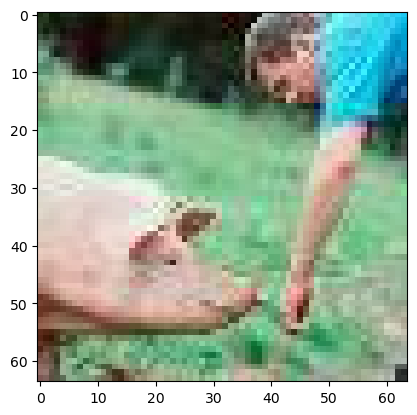

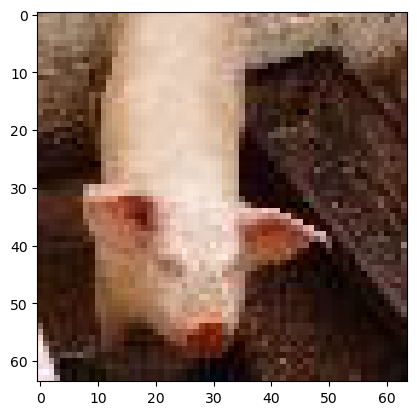

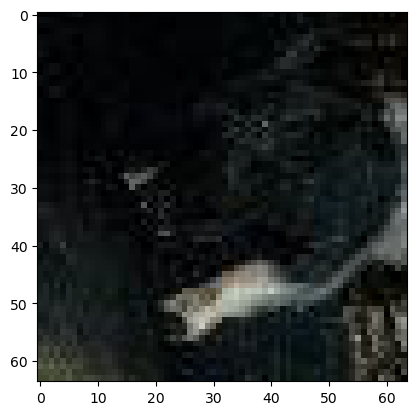

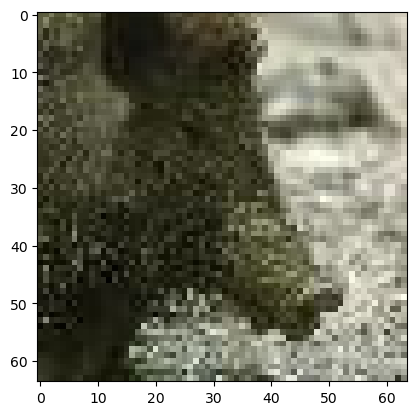

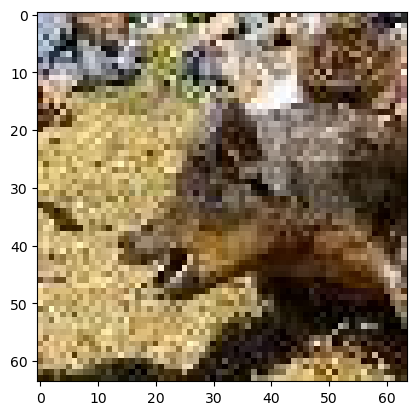

In [16]:
N = 5
class_name = 'pig'
folder     = os.path.join('.', 'data', 'train')

print("Visualizing class: {}".format(class_name))
visualize(N, class_name, folder)

### Step 3: Normalize data

Normalizing the data means getting the features in a similar range of values. This is an important step in your CNN pipeline. Making the features (here, pixels) in a similar data distribution helps the model converge.

We've already looped through the training dataset and found the channel-wise means and standard deviations for you. We've divided them by 255, since the PyTorch Tensors have values between [0,1]. The images are normalized by subtracting the means and dividing by the standard deviations.  

PyTorch has an easy method for integrating normalization into your machine learning pipeline - you create 
[transforms](https://pytorch.org/docs/master/torchvision/transforms.html?highlight=transform), which are just different data manipulations you can chain together. Before you pass an image to your model, it's fed through the transform first.

The transform below converts the images into the correct format and then applies the normalization.

In [17]:
dataset_means = [123./255., 116./255.,  97./255.]
dataset_stds  = [ 54./255.,  53./255.,  52./255.]


transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(dataset_means, dataset_stds)
        ])

###  Create Dataset and DataLoader for PyTorch model
The model we will soon create in PyTorch needs a way of understanding our dataset folder structure.

This has 2 steps:

1. Define a **[Dataset](https://pytorch.org/docs/master/data.html#torch.utils.data.Dataset)**
    - Tells the model where your data is and how to access it
    - Requires `__getitem__` function, which tells your model how to grab an image and label when needed
    - Requires `__len__` function, which returns the size of the dataset
    
   &nbsp; 
2. Define a **[DataLoader](https://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader)**
    - Tells the model how to sample from the dataset
    - Defines the _batch size_, which is the number of images propagated through the network during one forward pass before a gradient update

Run the cell below to create datasets and dataloaders.

In [18]:
BATCH_SIZE = 128

train_dataset = datasets.ImageFolder(os.path.join('.', 'data', 'train'),transform=transform)
val_dataset   = datasets.ImageFolder(os.path.join('.', 'data', 'val'),  transform=transform)
test_dataset   = datasets.ImageFolder(os.path.join('.', 'data', 'test'),  transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=True)
test_dataloader   = DataLoader(test_dataset,   batch_size=BATCH_SIZE, shuffle=True)


# Part 1: Fitting the data

### High-Level Overview
Now, we will attempt to fit the data using a convolutional neural network. This network will learn to classify input images into one of the 16 animal categories, based on the training data that we provide to it. We will use our validation dataset to get a sense of how the network performs on unseen data.

### Create a baseline model
Below we have defined a baseline model, which you will improve on in a later part of this project. There are two parts to defining a model:

1. `__init__`: Define the **layers** of your network. Check out torch.nn documentation for pre-implemented layers.

    &nbsp;
2. `forward`: Chains together the layers you defined in `__init__`, creating the **pipeline** for a forward pass (i.e. where the image goes when you feed it to the network). In our baseline, the image passes through a series of **convolution** layers followed by **ReLU** (Rectified Linear Unit) nonlinearities, followed by a couple **fully connected** layers.

### **<font color='red'>TODO : </font>** 

Implement the baseline model architecture in `student.py`. The architecture is the following:
- **conv1**: convolution layer with 6 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **conv2**: convolution layer with 12 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **conv3**: convolution layer with 24 output channels, kernel size of 3, stride of 2, padding of 1
- **ReLU** nonlinearity
- **fc**:    fully connected layer with 128 output features
- **ReLU** nonlinearity
- **cls**:   fully connected layer with 16 output features (the number of classes)



The feature map sizes in this case are calculated by dividing the input size by the _stride_ (how many pixels you slide the kernel over each time you do a convolution). For example, we started with a 64 x 64 image, passed it through the `conv1` layer with a stride of 2, giving an output size of 32 x 32. When you create your own model, it's important to pay attention to these sizes. You'll need to figure out the dimensions to the first Linear layer, which needs an input size equal to the number of pixels in your Tensor by that point in the network.


To verify that we added the correct layers above, we can **load the pretrained weights** into the architecture. The weights file essentially holds a dictionary, where the keys are the layer names and the values are the parameter weights. If your architecture is correct, you should be able to print the network and see the layers.

**Please define the forward pass manually rather than using nn.Sequential. Otherwise, the pretrained model weights won't load correctly.**

You'll have to create your own model, so make sure you understand the baseline architecture before proceeding!

In [19]:
import student

net_pretrained = student.AnimalBaselineNet()

# Load pretrained weights into network to check if architecture is correct
weights_path = os.path.join('.', 'models', 'baseline.pth')
net_pretrained.load_state_dict(torch.load(weights_path, map_location="cpu"))

for layer in net_pretrained.children():
    print(layer)


Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ReLU()
Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ReLU()
Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ReLU()
Linear(in_features=1536, out_features=128, bias=True)
ReLU()
Linear(in_features=128, out_features=16, bias=True)


###  Train the model

Great, we have our model and our data! There's two more steps before we can train:
- Decide what **loss function** you need. Here, we use [_cross entropy loss_](https://pytorch.org/docs/master/nn.html#crossentropyloss), typical for image classification.
- Decide how many **epochs** you will train your model for. One epoch means one pass of the full training dataset through your model. Here, we set it to 80. When you train your own model, you'll have to keep track of the losses to decide when to stop.
- Decide what **optimizer** you will use. An optimizer tells your model how to take steps along the gradient to try and reach a minimum. Here, we use the popular _Adam optimizer_ (if you're curious, here's the [paper](https://arxiv.org/pdf/1412.6980.pdf)). It adapts the learning rates for each parameter based on how quickly each parameter's gradient is changing. It's known as being more forgiving for less-than-optimal hyperparameter choices than other optimizers are.

We also redefine the network to start from scratch, rather than loading in pretrained weights.


In [20]:


net = student.AnimalBaselineNet()

criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr = 0.01)
epochs = 80

Time to train! For each epoch, the model does a forward and backward pass for training, and then just a forward pass for validation. But what are forward and backward passes?

- **Forward pass**: sends a batch of images through the network. Returns the output of the last linear layer, which has 16 values: each value is the likelihood that the image belongs to that particular class.
- **Backward pass**: calculates the loss and the gradient of the loss with respect to the model parameters. Optimizer updates the weights based on this gradient.

During training, we keep track of the loss and accuracy for both training & validation phases so we can visualize our model performance after it's done.

### **<font color='red'>TODO: </font>** 
Implement the `model_train` function in `student.py`. We will be running your `model_train` with your `AnimalBaselineNet` to check accuracy.

 
Something to think about: What do you notice about the train vs. validation performance? What might this mean about the model?


In [21]:


# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(epochs)
train_acc_history  = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_acc_history    = np.zeros(epochs)

start_time = datetime.now()

for epoch in range(epochs):
    
     # ============================ Training ==============================
    print("Training...")
    
    # Place network in training mode
    net.train()
    
    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    
    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        # [inputs] and [labels] is one batch of images and their classes
        # Function call to student
        curr_loss, curr_correct, curr_images = \
            student.model_train(net, inputs, labels, criterion, optimizer)
        
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

    # Update statistics for epoch
    train_loss_history[epoch] = running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("Epoch: {:d} | Train Avg. Loss: [{}] | Acc: {} on {} images\n".format(epoch,
          round(train_loss_history[epoch],4), train_acc_history[epoch], total_images) )
    
    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    net.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(val_dataloader):
        # Propagate batch through network
        outputs  = net(inputs)
                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size
        
    # Update statistics for validation data
    val_loss_history[epoch] = running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))



torch.save(net.state_dict(), os.path.join('.','models','my_baseline.pth'))


Training...
Epoch: 0 | Train Avg. Loss: [0.021] | Acc: 0.11675 on 8000.0 images

Validating...
Val Avg. Loss: [0.0229] Acc: 0.18375 on 800.0 images

Training...
Epoch: 1 | Train Avg. Loss: [0.0191] | Acc: 0.208375 on 8000.0 images

Validating...
Val Avg. Loss: [0.0207] Acc: 0.22125 on 800.0 images

Training...
Epoch: 2 | Train Avg. Loss: [0.0177] | Acc: 0.272 on 8000.0 images

Validating...
Val Avg. Loss: [0.0193] Acc: 0.265 on 800.0 images

Training...
Epoch: 3 | Train Avg. Loss: [0.0167] | Acc: 0.30625 on 8000.0 images

Validating...
Val Avg. Loss: [0.0193] Acc: 0.2925 on 800.0 images

Training...
Epoch: 4 | Train Avg. Loss: [0.0156] | Acc: 0.354375 on 8000.0 images

Validating...
Val Avg. Loss: [0.0196] Acc: 0.28125 on 800.0 images

Training...
Epoch: 5 | Train Avg. Loss: [0.0142] | Acc: 0.417 on 8000.0 images

Validating...
Val Avg. Loss: [0.0206] Acc: 0.27375 on 800.0 images

Training...
Epoch: 6 | Train Avg. Loss: [0.0126] | Acc: 0.481125 on 8000.0 images

Validating...
Val Avg. 

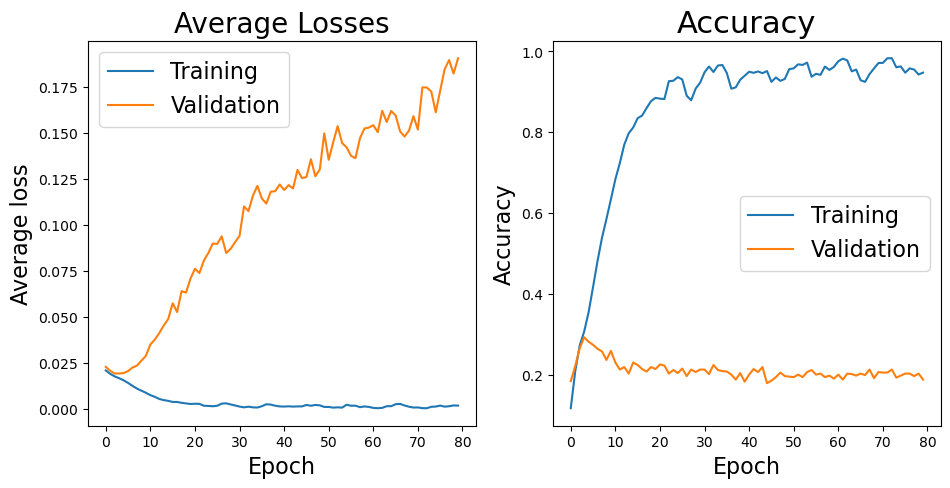

In [22]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

ax = axs[0]
ax.set_title("Average Losses", fontsize=20)
ax.plot(train_loss_history, label="Training")
ax.plot(val_loss_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Average loss", fontsize=16)
ax.legend(loc="best",         fontsize=16)

ax = axs[1]
ax.set_title("Accuracy", fontsize=22)
ax.plot(train_acc_history, label="Training")
ax.plot(val_acc_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Accuracy",     fontsize=16)
ax.legend(loc="best",         fontsize=16)

# Part 2: Building a better model

Now, it's your turn to build a model. Your goal is to get an accuracy of at least 35% on the validation set. The only thing you can change is your model architecture. Think: is the model underfitting or overfitting?


### <font color='red'>TODO </font>:
In `student.py`, define your own `AnimalStudentNet` model architecture. We will be running your `model_train` with your `AnimalStudentNet` when grading to check consistency. Please make sure you follow the following restrictions when building your network. 
#### Restrictions ####
* Model must be below 5 MB
* You may not use pretrained models or model architectures from the internet. We are expecting you to build one from scratch. 
* You may not use any other training set than the one provided in the assignment. 
* You may not hand-label the test set. 
* You may not share models between groups. 



In [23]:
import importlib
importlib.reload(student)

net = student.AnimalStudentNet()

for layer in net.children():
    print(layer)

Conv2d(3, 6, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dropout(p=0.25, inplace=False)
Conv2d(6, 12, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dropout(p=0.25, inplace=False)
Conv2d(12, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
ReLU()
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
Dropout(p=0.25, inplace=False)
Linear(in_features=1536, out_features=128, bias=True)
ReLU()
Dropout(p=0.5, inplace=False)
Linear(in_features=128, out_features=16, bias=True)


In [24]:

# Keep track of average losses, training accuracy and validation accuracy for each epoch
train_loss_history = np.zeros(epochs)
train_acc_history  = np.zeros(epochs)
val_loss_history   = np.zeros(epochs)
val_acc_history    = np.zeros(epochs)

start_time = datetime.now()
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(net.parameters(), lr = 0.01)
for epoch in range(epochs):
    
     # ============================ Training ==============================
    print("Training...")
    
    # Place network in training mode
    net.train()
    
    # Initialize running epoch loss and number correctly classified
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(train_dataloader):
        # [inputs] and [labels] is one batch of images and their classes

        
        #  ***** Function call to student *****
        curr_loss, curr_correct, curr_images = \
            student.model_train(net, inputs, labels, criterion, optimizer)
        running_loss += curr_loss
        num_correct += curr_correct
        total_images += curr_images

    # Update statistics for epoch
    train_loss_history[epoch] = running_loss / total_images
    train_acc_history[epoch]  = float(num_correct)  / float(total_images)
    print("\n Epoch: {:d} | Train Avg. Loss: [{}] | Acc: {} on {} images\n".format(epoch,
          round(train_loss_history[epoch],4), train_acc_history[epoch], total_images) )
    
    # ============================ Validation ==============================
    print("Validating...")
    # Place network in testing mode (won't need to keep track of gradients)
    net.eval()
    
    running_loss   = 0.0
    num_correct    = 0.0
    total_images   = 0.0
    
    for batch_num, (inputs, labels) in enumerate(val_dataloader):
        
        # Propagate batch through network
        outputs  = net(inputs)

                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size
        
    # Update statistics for validation data
    val_loss_history[epoch] = running_loss / total_images
    val_acc_history[epoch]  = float(num_correct)  / float(total_images) 
    print("Val Avg. Loss: [{}] Acc: {} on {} images\n".format(
        round(val_loss_history[epoch],4), val_acc_history[epoch], total_images))
    
print("Time Elapsed: {} seconds".format(
    (datetime.now() - start_time).total_seconds()))



torch.save(net.state_dict(), os.path.join('.','models','my_new_model.pth'))

Training...


ValueError: Expected input batch_size (2) to match target batch_size (128).

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(11,5))

ax = axs[0]
ax.set_title("Student Avg Losses", fontsize=20)
ax.plot(train_loss_history, label="Training")
ax.plot(val_loss_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Average loss", fontsize=16)
ax.legend(loc="best",         fontsize=16)

ax = axs[1]
ax.set_title("Student Accuracy", fontsize=22)
ax.plot(train_acc_history, label="Training")
ax.plot(val_acc_history,   label="Validation")
ax.set_xlabel("Epoch",        fontsize=16)
ax.set_ylabel("Accuracy",     fontsize=16)
ax.legend(loc="best",         fontsize=16)

### Test accuracies ###
Let us now compute test accuracies.

In [ ]:
net1 = student.AnimalBaselineNet()
weights_path = os.path.join('.', 'models', 'my_baseline.pth')
net1.load_state_dict(torch.load(weights_path, map_location="cpu"))



num_correct = 0
total_images = 0
running_loss = 0
for batch_num, (inputs, labels) in enumerate(test_dataloader):
        
        # Propagate batch through network
        outputs  = net1(inputs)
                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size

print('Accuracy of baseline is {:f}'.format(float(num_correct)/float(total_images)))

num_correct = 0
total_images = 0
running_loss = 0        
 
net2 = student.AnimalStudentNet()
weights_path = os.path.join('.', 'models', 'my_new_model.pth')
net2.load_state_dict(torch.load(weights_path, map_location="cpu"))

for batch_num, (inputs, labels) in enumerate(test_dataloader):
        
        # Propagate batch through network
        outputs  = net2(inputs)
                                                 
        # Calculate loss
        loss     = criterion(outputs, labels.squeeze())
                                                 
        # Prediction is class with highest class score
        _, preds = torch.max(outputs, 1)
        
        running_loss  += loss.item()
        num_correct   += torch.sum(preds == labels.data.reshape(-1))
        total_images  += labels.data.numpy().size

print('Accuracy of new model is {:f}'.format(float(num_correct)/float(total_images)))
    

# Part 3: Adversarial Examples

Convolutional neural networks are extremely powerful models when it comes to images; today, they are used extensively in drug discovery, disease detection, self-driving cars, and more. However, they are far from perfect. Turns out, these networks can be tricked very easily, using the concept of _adversarial examples_. In this part, we will generate adversarial examples to trick our own model.

#### High-Level Overview
We start with an image, $I$, that is classified correctly as class $C$. Our objective is to **manipulate the image** $I$ by adding **small changes** to it which would make the network **misclassify** the image. We can do so by observing the gradients produced within the model. Essentially, we find the direction in which we must change each input image pixel to maximize the loss, and we give the image's pixels a slight nudge in that direction. We get a new image, $I_{perturbed}$, that the network misclassifies.

The scary part is that $I_{perturbed}$ contains tiny, imperceptible changes relative to $I$; to the human eye, $I$ and $I_{perturbed}$ visually look like the same image. Yet, the model perceives these two images completely differently.


#### Implementation

Below is a loop that loads the baseline model and sends images through it one by one. When it classifies an image correctly, you will create an adversarial image and see if you can fool the network into misclassifying it.


For each correctly classified image, we need the gradient of the loss with respect to the image: $G = \frac{\partial_{loss}}{\partial_{I}}$. We use this to create a matrix $\alpha$ (defined below) of perturbations and add it to the original image:

$$I_{perturbed} = I + \alpha$$

$\alpha$ and $G$ have the same dimensions. $\alpha$ is a matrix where the absolute value of each element is a small $\epsilon$, yet the _sign_ (positive or negative) of $\alpha[i,j]$ is equal to the _sign_ of $G[i,j]$. This makes sense: if the gradient value at some pixel is  negative, then you want to follow that negative slope and add negative noise value to your original image.


### **<font color="red">TODO : </font>**
Complete the `get_adversarial` in `student.py`. Run the cells below. Your function should get **at least 50% of adversarial images misclassified** with an `epsilon=0.02`.



In [ ]:
import importlib
importlib.reload(student)

# Load pretrained baseline model
net          = student.AnimalBaselineNet()
weights_path = os.path.join('.', 'models', 'baseline.pth')
net.load_state_dict(torch.load(weights_path, map_location="cpu"))

val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True)

criterion = nn.CrossEntropyLoss()
epsilon = 0.02

original_imgs      = []
original_preds     = []

adversarial_imgs   = []
adversarial_preds  = []
adversarial_noises = []


for i, (img, label) in enumerate(val_dataloader):
    
    # Set image tensor so gradient is calculated
    img.requires_grad = True
    
    output = net(img)

    init_pred = output.max(1, keepdim=True)[1]
    
    if init_pred == label:
        # Image classified correctly; generate adversarial image
        perturbed_img, noise = student.get_adversarial(img, output, label, net, criterion, epsilon)
    
        adversarial_output = net(perturbed_img)
        adversarial_pred   = adversarial_output.max(1, keepdim=True)[1]
        original_imgs.append(img[0].detach().numpy())
        original_preds.append(init_pred)
        adversarial_imgs.append(perturbed_img[0].detach().numpy())
        adversarial_preds.append(adversarial_pred)
        adversarial_noises.append(noise.squeeze().detach().numpy())
    


print("Out of total {} images generated, {} % of adversarial images misclassified".format(
    len(original_imgs),
    round((torch.sum(torch.Tensor(original_preds) != torch.Tensor(adversarial_preds)).item())
        / len(original_imgs) * 100., 4)))



In [ ]:
num_desired_adversarial = 4

fig, axs = plt.subplots(num_desired_adversarial, 3, figsize=(10,3*num_desired_adversarial))
matplotlib.rcParams.update({'font.size': 14})

def normalize(img):
        img = img.astype(float)
        img= img - np.min(img)
        img = img / np.max(img)
        return img


for i in range(num_desired_adversarial):
    ax = axs[i,0]
    ax.set_title('Original: {}'.format(classes[original_preds[i]]))
    ax.imshow(normalize(original_imgs[i].transpose(1,2,0)))
    
    ax = axs[i,1]
    ax.set_title('Adversarial Noise')
    ax.imshow(normalize(adversarial_noises[i].transpose(1,2,0)))
    
    ax = axs[i,2]
    ax.set_title('Adversarial: {}'.format(classes[adversarial_preds[i]]))
    ax.imshow(normalize(adversarial_imgs[i].transpose(1,2,0)))
    
plt.tight_layout()
plt.show()
    